# Imports

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import joblib

import matplotlib.pyplot as plt
import seaborn as sns


# Nettoyage des données

Filtrer le nombres de pieces, supprimez les colones inutiles et les lignes nulles.

In [ ]:
# Chargement + filtrage 4 pièces

df = pd.read_csv("data/lille_2022.csv")
df_4p = df[df["Nombre pieces principales"] == 4].copy()


# Nettoyage basique des libellés

df_4p["Type local"] = df_4p["Type local"].str.upper().str.strip()


# Création de la cible prix_m2

df_4p["prix_m2"] = df_4p["Valeur fonciere"] / df_4p["Surface reelle bati"]


# Traitement spécifique de `Surface terrain`
# (Option simple : 0 pour les apparts, médiane pour les maisons)

# Booléen pour savoir si c’est un appart
df_4p["est_appart"] = df_4p["Type local"] == "APPARTEMENT"

# 0 pour les appartements
df_4p.loc[df_4p["est_appart"], "Surface terrain"] = (
    df_4p.loc[df_4p["est_appart"], "Surface terrain"].fillna(0)
)

# médiane terrain pour les maisons (plus stable que 0)
median_terrain = (
    df_4p.loc[~df_4p["est_appart"], "Surface terrain"].median()
)
df_4p.loc[~df_4p["est_appart"], "Surface terrain"] = (
    df_4p.loc[~df_4p["est_appart"], "Surface terrain"]
      .fillna(median_terrain)
)


# Sélection des colonnes utiles

cols_keep = [
    "Surface reelle bati",
    "Surface terrain",      # maintenant toujours renseignée
    "Nombre de lots",
    "Type local",
    "prix_m2"
]
df_4p = df_4p[cols_keep].copy()


# 5. Suppression des lignes restantes avec NaN

df_4p_clean = df_4p.dropna()

print(df_4p_clean["Type local"].value_counts())


Type local
APPARTEMENT    435
MAISON         354
Name: count, dtype: int64


# Outilisers

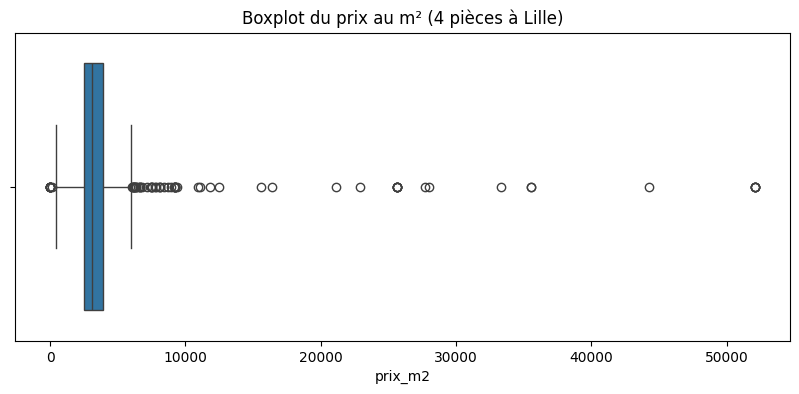

In [88]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_4p_clean["prix_m2"])
plt.title("Boxplot du prix au m² (4 pièces à Lille)")
plt.show()

In [89]:
q1 = df_4p_clean["prix_m2"].quantile(0.25)
q3 = df_4p_clean["prix_m2"].quantile(0.75)
iqr = q3 - q1

borne_min = q1 - 1.5 * iqr
borne_max = q3 + 1.5 * iqr

nb_total = df_4p_clean.shape[0]
nb_outliers = df_4p_clean[
    (df_4p_clean["prix_m2"] < borne_min) |
    (df_4p_clean["prix_m2"] > borne_max)
].shape[0]

print(f"Nombre total : {nb_total}")
print(f"Outliers selon IQR : {nb_outliers} ({nb_outliers / nb_total * 100:.2f}%)")


Nombre total : 789
Outliers selon IQR : 69 (8.75%)


# Netoyyage des données

In [ ]:
df_4p_cleaner = df_4p_clean[
    (df_4p_clean["prix_m2"] >= 1000) &
    (df_4p_clean["prix_m2"] <= 9000)
]

# Verification outliers après netoyyage 

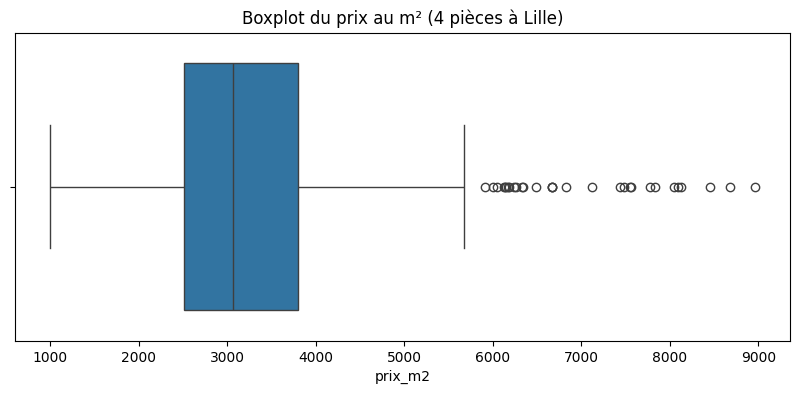

In [91]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_4p_cleaner["prix_m2"])
plt.title("Boxplot du prix au m² (4 pièces à Lille)")
plt.show()

In [92]:
q1 = df_4p_cleaner["prix_m2"].quantile(0.25)
q3 = df_4p_cleaner["prix_m2"].quantile(0.75)
iqr = q3 - q1

borne_min = q1 - 1.5 * iqr
borne_max = q3 + 1.5 * iqr

nb_total = df_4p_cleaner.shape[0]
nb_outliers = df_4p_cleaner[
    (df_4p_cleaner["prix_m2"] < borne_min) |
    (df_4p_cleaner["prix_m2"] > borne_max)
].shape[0]

print(f"Nombre total : {nb_total}")
print(f"Outliers selon IQR : {nb_outliers} ({nb_outliers / nb_total * 100:.2f}%)")


Nombre total : 740
Outliers selon IQR : 30 (4.05%)


## Séparation Appartement/Maison

In [93]:
df_appart = df_4p_cleaner[df_4p_clean["Type local"] == "APPARTEMENT"].copy()
df_maison = df_4p_cleaner[df_4p_clean["Type local"] == "MAISON"].copy()

/var/folders/sd/z1tr_bxd4lscwlwq_6jzxhkc0000gn/T/ipykernel_22791/1531014300.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_appart = df_4p_cleaner[df_4p_clean["Type local"] == "APPARTEMENT"].copy()
/var/folders/sd/z1tr_bxd4lscwlwq_6jzxhkc0000gn/T/ipykernel_22791/1531014300.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_maison = df_4p_cleaner[df_4p_clean["Type local"] == "MAISON"].copy()


In [94]:
print(f"Appartements : {df_appart.shape[0]} lignes")
print(f"Maisons : {df_maison.shape[0]} lignes")


Appartements : 391 lignes
Maisons : 349 lignes


# Train

In [95]:
features = ["Surface reelle bati", "Surface terrain", "Nombre de lots"]

# Appartements
X_app = df_appart[features]
y_app = df_appart["prix_m2"]

# Maisons
X_mai = df_maison[features]
y_mai = df_maison["prix_m2"]


In [96]:
X_app_train, X_app_test, y_app_train, y_app_test = train_test_split(X_app, y_app, test_size=0.2, random_state=42)
X_mai_train, X_mai_test, y_mai_train, y_mai_test = train_test_split(X_mai, y_mai, test_size=0.2, random_state=42)


# Pipeline

In [ ]:
# Pipeline LinearRegression
pipe_linreg_app = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
    ])
pipe_linreg_mai = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
    ])

In [98]:
pipe_linreg_app.fit(X_app_train, y_app_train)
pipe_linreg_mai.fit(X_mai_train, y_mai_train)


,steps,"[('scaler', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [99]:
y_app_pred = pipe_linreg_app.predict(X_app_test)

mse = mean_squared_error(y_app_test, y_app_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_app_test, y_app_pred)
r2 = r2_score(y_app_test, y_app_pred)

print(f"Linear Regression - Appartements :")
print(f"  RMSE : {rmse:.2f}")
print(f"  MAE  : {mae:.2f}")
print(f"  R²   : {r2:.3f}")


Linear Regression - Appartements :
  RMSE : 1295.67
  MAE  : 948.99
  R²   : 0.129


In [100]:
# y_app.head() 
df_appart[["prix_m2"]].describe()

,prix_m2
count,391.000000
mean,3505.792780
std,1276.593529
min,1000.000000
25%,2636.014193
50%,3202.247191
75%,4062.781532
max,8958.333333


In [101]:
y_mai_pred = pipe_linreg_mai.predict(X_mai_test)

mse = mean_squared_error(y_mai_test, y_mai_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_mai_test, y_mai_pred)
r2 = r2_score(y_mai_test, y_mai_pred)

print(f"Linear Regression - Maisons :")
print(f"  RMSE : {rmse:.2f}")
print(f"  MAE  : {mae:.2f}")
print(f"  R²   : {r2:.3f}")


Linear Regression - Maisons :
  RMSE : 1055.94
  MAE  : 768.01
  R²   : -0.034


In [102]:
df_maison[["prix_m2"]].describe()

,prix_m2
count,349.000000
mean,3013.333535
std,1043.091545
min,1005.882353
25%,2333.333333
50%,2863.636364
75%,3482.142857
max,8046.875000


In [103]:
def compare_models(
        df: pd.DataFrame,
        feature_cols: list,
        target_col: str = "prix_m2",
        test_size: float = 0.2,
        random_state: int = 42,
        optimize_trees: bool = False,
    ) -> pd.DataFrame:
    """
    Entraîne LinearRegression, DecisionTreeRegressor et RandomForestRegressor
    (avec ou sans GridSearch) puis renvoie un DataFrame récapitulatif
    des métriques sur le jeu de test.
    """
    # -------------------------------------------------
    # 1. Séparation X / y + train / test
    # -------------------------------------------------
    X = df[feature_cols]
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # -------------------------------------------------
    # 2. Pré-processing (num + cat) — simple et sûr
    # -------------------------------------------------
    num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

    preproc = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), num_cols),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
        ]
    )

    # -------------------------------------------------
    # 3. Liste des modèles
    # -------------------------------------------------
    models = {
        "LinearRegression": LinearRegression(),
        "DecisionTree": DecisionTreeRegressor(random_state=random_state),
        "RandomForest": RandomForestRegressor(random_state=random_state),
    }

    # -------------------------------------------------
    # 4. Optionnel : GridSearch rapide sur les arbres
    # -------------------------------------------------
    if optimize_trees:
        tree_grid = {"model__max_depth": [None, 5, 10, 20]}
        rf_grid   = {
            "model__n_estimators": [100, 300],
            "model__max_depth": [None, 5, 10]
        }

    results = []

    # -------------------------------------------------
    # 5. Boucle d’entraînement + évaluation
    # -------------------------------------------------
    for name, estimator in models.items():

        pipe = Pipeline([
            ("prep", preproc),
            ("model", estimator)
        ])

        if optimize_trees and name == "DecisionTree":
            pipe = GridSearchCV(pipe, tree_grid, cv=5, n_jobs=-1,
                                scoring="neg_mean_squared_error")
        elif optimize_trees and name == "RandomForest":
            pipe = GridSearchCV(pipe, rf_grid, cv=3, n_jobs=-1,
                                scoring="neg_mean_squared_error")

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        mse  = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_test, y_pred)
        r2   = r2_score(y_test, y_pred)

        results.append({
            "Modèle": name,
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2),
            "R²": round(r2, 3),
        })

    return pd.DataFrame(results).set_index("Modèle")


In [104]:
# 1) Sélection des colonnes explicatives
features = ["Surface reelle bati", "Surface terrain", "Nombre de lots"]

# 2) Appartements
df_appart = df_4p_clean[df_4p_clean["Type local"] == "APPARTEMENT"]
results_app = compare_models(df_appart, feature_cols=features)
print("📊 Appartements\n", results_app, "\n")

# 3) Maisons
df_maison = df_4p_clean[df_4p_clean["Type local"] == "MAISON"]
results_mai = compare_models(df_maison, feature_cols=features, optimize_trees=True)
print("📊 Maisons (avec tuning arbres)\n", results_mai)


📊 Appartements
                      RMSE      MAE     R²
Modèle                                   
LinearRegression  5430.76  2368.61  0.279
DecisionTree      4265.78  1650.43  0.555
RandomForest      3739.26  1530.53  0.658 

📊 Maisons (avec tuning arbres)
                      RMSE     MAE     R²
Modèle                                  
LinearRegression  1033.68  791.28  0.024
DecisionTree      1239.56  947.19 -0.403
RandomForest      1088.16  847.08 -0.081


In [105]:
# 1. Colonnes explicatives
features = ["Surface reelle bati", "Surface terrain", "Nombre de lots"]

# 2. Appartements : RandomForest (meilleur modèle pour APPARTEMENTS)
X_app = df_appart[features]
y_app = df_appart["prix_m2"]

model_appart = RandomForestRegressor(random_state=42)
model_appart.fit(X_app, y_app)

# 3. Maisons : LinearRegression (le "moins pire" pour MAISONS)
X_mai = df_maison[features]
y_mai = df_maison["prix_m2"]

model_maison = LinearRegression()
model_maison.fit(X_mai, y_mai)

# 4. Sauvegarde des modèles
os.makedirs("models", exist_ok=True)
joblib.dump(model_appart, "models/model_lille_appartement.pkl")
joblib.dump(model_maison, "models/model_lille_maison.pkl")

print("✅ Modèles enregistrés dans le dossier 'models/'")


✅ Modèles enregistrés dans le dossier 'models/'
